## Taxi Data Download & Preprocessing with BlazingSQL 
In this notebook we will:
1. Download 18 months (Jan 2015-June 2016) of NYC Yellow Cab Taxi data (~30.95GB total) from AWS. 
2. Preprocess / ETL each month with BlazingSQL, saving the results locally to CSV.
3. Read back some of our preprocessed data for visualization with Datashader.

#### Prerequisites 
To run this notebook you simply need to have [Datashader installed](https://datashader.org/getting_started/index.html#installation) and a [RAPIDS compatible GPU](https://medium.com/dropout-analytics/which-gpus-work-with-rapids-ai-f562ef29c75f?source=friends_link&sk=3ad1082fbd38df262bf04c164dbb3c0a) set up.

#### Imports

In [1]:
import time
# start the timer
now = time.time()

import os
import sys
import urllib
import numpy as np

# import BlazingSQL
try:
    from blazingsql import BlazingContext
    print("You're good to go!")
# looks like we don't have it installed
except ImportError:
    # see if we want to install it
    ask = input('Unable to import BlazingSQL package, would you like to install it now? (y/n) ')
    # if we do
    if ask.lower().strip() == 'y':
        # go ahead and install
        from utils.sql_check import bsql_start
        print(bsql_start())
    else:
        # not installing at this time
        print('Ok, you can find the script here: https://docs.blazingdb.com/docs/install-via-conda or run utils/sql_check.py if you would like to install it in the future.')

You're good to go!


## Check for / Download Data
The cell below will download the full year of 2015 and the first half of 2016 yellow cab data. We are only downloading the first half of 2016 because the recording practices changed July 2016, and I have not yet made time to create the appropriate preprocessing script for the latter half of that year.
- Time
    - Full data download Wall time: 6min 3s on AWS 
- Size
    - 2015: ~20.07 GB total (12 CSV files, January-December)
    - 2016: ~10.88 GB total (6 CSV files, January-June)
    - Total 215,519,509 rows 

In [2]:
%%time
def data_check(file_name, base_url='https://s3.amazonaws.com/nyc-tlc/trip+data/', data_dir='data/'):
    """
    1. check if the given {file_name} exists locally in {data_dir}
    2. download from {base_url} & save in {data_dir) if not
    """
    # tag cloud & relative local paths to data
    local_data = data_dir + file_name
    cloud_data = base_url + file_name
    # do we already have the file?
    if not os.path.isfile(local_data):
        # we don't, let me know we're downloading it now, then download it
        print(f'Downloading {cloud_data[8:]} to {local_data}')
        urllib.request.urlretrieve(cloud_data, local_data)
    # we already have data
    else:
        # let me know this is the case
        print(f'{local_data} already downloaded')

        
# january - december
for month in range(1, 13):
    # check if we are in double digit months
    if month < 10:
        # add 0 so we have the correct path
        month = f'0{month}'
    # tag file name for this month (default year to 2015)
    fn = f'yellow_tripdata_2015-{month}.csv'
    # check this month's data for 2015 
    data_check(file_name=fn)
    # are we in the first half of the year?
    if int(month) < 7:
        # check this month's data for 2016
        data_check(file_name=fn.replace('2015', '2016'))

CPU times: user 1min 10s, sys: 1min 28s, total: 2min 39s
Wall time: 5min 48s


# ETL - Clean Data

#### Start up BlazingSQL

In [2]:
%%time
# connect to BlazingSQL
bc = BlazingContext()

BlazingContext ready
CPU times: user 1.15 s, sys: 575 ms, total: 1.73 s
Wall time: 1.88 s


#### Create Tables
These take up ~459MiB GPU memory.

In [4]:
%%time
# tag path to current working directory
cwd = os.getcwd()
# create tables for all 12 CSV files (of each year)
for month in range(1, 13):
    # adjust month format if not in double digit months yet
    if month < 10:
        month = f'0{month}'
    # tag path to this month's data (default year to 2015)
    data_path = f'{cwd}/data/yellow_tripdata_2015-{month}.csv'
    # create this month's 2015 table
    bc.create_table(f'taxi_2015_{month}', data_path, header=0)
    # are we in 1st half of the year
    if int(month) < 7:
        # create this month's 2016 table
        bc.create_table(f'taxi_2016_{month}', data_path.replace('2015', '2016'), header=0)

CPU times: user 121 ms, sys: 10.6 ms, total: 132 ms
Wall time: 124 ms


### Define query 

In [5]:
%%time
# tag origin shift, pi & fractions
o_shift = 2 * np.pi * 6378137 / 2

# filter data to select lat & longitude regions and rename lat/lng columns
focus = f'''
        SELECT 
            VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, 
            trip_distance, RatecodeID, store_and_fwd_flag, payment_type, fare_amount,
            extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, 
            pickup_longitude * {o_shift} / 180 AS pickup_x, 
            LOG10(TAN(((90 + pickup_latitude) * {np.pi} / 360))) / {np.pi} / 180 * {o_shift} / 180 AS pickup_y,
            dropoff_longitude * {o_shift} / 180 AS dropoff_x, 
            LOG10(TAN(((90 + dropoff_latitude) * {np.pi} / 360))) / {np.pi} / 180 * {o_shift} / 180 AS dropoff_y
        FROM 
            big_taxi
            WHERE
                pickup_longitude < -73.75 AND pickup_longitude > -74.15
                AND dropoff_longitude < -73.75 AND dropoff_longitude > -74.15
                AND pickup_latitude > 40.68 AND pickup_latitude < 40.84
                AND dropoff_latitude > 40.68 AND dropoff_latitude < 40.84
                '''

CPU times: user 14 µs, sys: 0 ns, total: 14 µs
Wall time: 16.5 µs


#### Execute & Save Results
Total size shrinks ~7.436% after processing to 18.94 GB (135,216,505 rows) for 2015 & 8.99 GB (64,277,707 rows) for 2016.

In [6]:
%%time
def process_data(file_name, query=focus):
    """
    1. preprocess the given table {file_name} for Datashader
    2. save results to {file_name} in data directory
    3. delete origional file 
    4. drop the table from BlazingContext
    """
    # what are we doing?
    print(f'processing {file_name}')
    # refocus query this month's table
    query = query.replace('big_taxi', file_name)
    # run query 
    gdf = bc.sql(query)
    # how many records (rows) remain?
    print(f'len({file_name}) = {len(gdf)}\n')
    # save results to CSV
    gdf.to_csv(f'data/{file_name}.csv', index=False)
    # pull the year from the file name & delete this month's origional CSV file
    year = file_name.split('_')[1]
    os.remove(f'data/yellow_tripdata_{year}-{month}.csv')
    # drop this month's table from BlazingContext
    bc.drop_table(file_name)
    
    
# january - december
for month in range(1, 13):
    # adjust month format if not in double digit months yet
    if month < 10:
        month = f'0{month}'
    # tag this month's table (default year to 2015) 
    this_month = f'taxi_2015_{month}'
    # process this month in 2015
    process_data(file_name=this_month)
    # are we in the first half of the year?
    if int(month) < 7:
        # yes, so process this month in 2016 too
        process_data(file_name=this_month.replace('2015', '2016'))

processing taxi_2015_01
len(taxi_2015_01) = 11842094

processing taxi_2016_01
len(taxi_2016_01) = 10097867

processing taxi_2015_02
len(taxi_2015_02) = 11548134

processing taxi_2016_02
len(taxi_2016_02) = 10577970

processing taxi_2015_03
len(taxi_2015_03) = 12340770

processing taxi_2016_03
len(taxi_2016_03) = 11315944

processing taxi_2015_04
len(taxi_2015_04) = 12109368

processing taxi_2016_04
len(taxi_2016_04) = 11057963

processing taxi_2015_05
len(taxi_2015_05) = 12145534

processing taxi_2016_05
len(taxi_2016_05) = 10927188

processing taxi_2015_06
len(taxi_2015_06) = 11407389

processing taxi_2016_06
len(taxi_2016_06) = 10300775

processing taxi_2015_07
len(taxi_2015_07) = 10704615

processing taxi_2015_08
len(taxi_2015_08) = 10267463

processing taxi_2015_09
len(taxi_2015_09) = 10368858

processing taxi_2015_10
len(taxi_2015_10) = 11399728

processing taxi_2015_11
len(taxi_2015_11) = 10471600

processing taxi_2015_12
len(taxi_2015_12) = 10610952

CPU times: user 1min 45s, sy

## Visualize Results
Now we're going to make sure we preprocessed the data correctly by visualizing with Datashader. 

To keep this process quick, we'll just use the first & middle (Jan & Aug '15) and last (June '16) months processed.

#### Imports

In [3]:
%%time
# import Datashader & friends
import datashader as ds
from colorcet import fire, rainbow
from datashader import transfer_functions as tf

CPU times: user 9.13 s, sys: 306 ms, total: 9.44 s
Wall time: 9.36 s


#### Load Data

In [8]:
%%time
# create table from every 3rd month processed January 2015 - June 2016
paths = [cwd + f'/data/taxi_20{i}.csv' for i in ['15_01', '15_04', '15_07', '15_10', '16_01', '16_04']]
bc.create_table('third_taxi', paths, header=0)

CPU times: user 9.87 ms, sys: 273 µs, total: 10.1 ms
Wall time: 11.6 ms


#### Query & Visualize

Thanks to Datashader's support for GPU DataFrames, we can pass our query results directly into `.points()` for visualization.

In [9]:
%%time
# lay out the canvas w/ dropoff locations 
agg = ds.Canvas().points(bc.sql('SELECT dropoff_x, dropoff_y FROM third_taxi'), 'dropoff_x', 'dropoff_y')

CPU times: user 15.6 s, sys: 10.7 s, total: 26.3 s
Wall time: 28.1 s


CPU times: user 21.1 ms, sys: 4.53 ms, total: 25.6 ms
Wall time: 24.6 ms


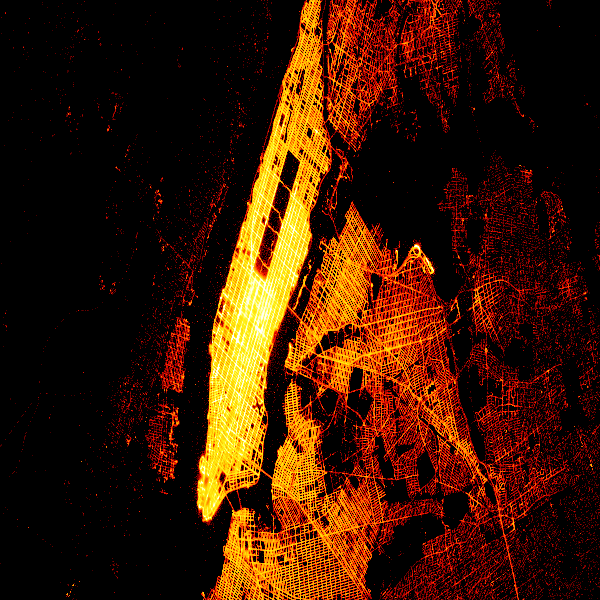

In [10]:
%%time
# shade in the picture w/ fire
tf.set_background(tf.shade(agg, cmap=fire), "black")

In [10]:
then = time.time()
total_time = then - now
# what was our total runtime?
print(f'{int(total_time//60)} min {int(total_time%60)} sec\nTOTAL TIME: {total_time}')

11 min 15 sec
TOTAL TIME: 675.2000908851624
